In [1]:
import numpy as np
import pandas as pd

import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
%time

df=pd.read_csv('data/football.csv',
            usecols={'date','home_team','away_team','home_score','away_score','tournament','Coordinate_home1',
                    'Coordinate_home2','Coordinate_away1','Coordinate_away2','Coordinate_match1','Coordinate_match2'},
            dtype = {'date':'str','home_team':'str','away_team':'str','home_score':np.int8,
                                         'away_score':np.int8,'tournament':'str','Coordinate_home1':np.float32,
                    'Coordinate_home2':np.float32,'Coordinate_away1':np.float32,'Coordinate_away2':np.float32,
                     'Coordinate_match1':np.float32,'Coordinate_match2':np.float32},parse_dates = True)

Wall time: 0 ns


In [3]:
df['date'] = pd.to_datetime(df['date'])
df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month
df=df[df['year']>=2000]
df['home_result']= df['home_score']-df['away_score']
df['result']=np.where(df['home_result']>0,1,np.where(df['home_result']<0,-1,0))

In [4]:
df=df[abs(df['home_result'])<=2]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7955 entries, 0 to 14312
Data columns (total 16 columns):
date                 7955 non-null datetime64[ns]
home_team            7955 non-null object
away_team            7955 non-null object
home_score           7955 non-null int8
away_score           7955 non-null int8
tournament           7955 non-null object
Coordinate_home1     7955 non-null float32
Coordinate_home2     7955 non-null float32
Coordinate_away1     7955 non-null float32
Coordinate_away2     7955 non-null float32
Coordinate_match1    7955 non-null float32
Coordinate_match2    7955 non-null float32
year                 7955 non-null int64
month                7955 non-null int64
home_result          7955 non-null int8
result               7955 non-null int32
dtypes: datetime64[ns](1), float32(6), int32(1), int64(2), int8(3), object(3)
memory usage: 675.9+ KB


In [6]:
def deg2rad(deg):
    return(deg*np.pi/180.00)

def distcoor(lat1,lat2,lon1,lon2):
    R= 6371.00
    dlat=deg2rad(lat2-lat1)
    dlon=deg2rad(lon2-lon1)
    a= np.sin(dlat/2.0)*np.sin(dlat/2.0)+np.cos(deg2rad(lat1))*np.cos(deg2rad(lat2))*np.sin(dlon/2.0)*np.sin(dlon/2.0)
    c= 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d= R*c
    return(d)


In [7]:
df['home_dist']=distcoor(df['Coordinate_match1'],df['Coordinate_home1'],df['Coordinate_match2'],df['Coordinate_home2'])
df['away_dist']=distcoor(df['Coordinate_match1'],df['Coordinate_away1'],df['Coordinate_match2'],df['Coordinate_away2'])

In [8]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,Coordinate_home1,Coordinate_home2,Coordinate_away1,Coordinate_away2,Coordinate_match1,Coordinate_match2,year,month,home_result,result,home_dist,away_dist
0,2003-11-23,Afghanistan,Turkmenistan,0,2,FIFA World Cup qualification,34.528057,69.172226,37.950001,58.383335,34.528057,69.172226,2003,11,-2,-1,0.0,1038.914185
2,2015-03-29,Albania,Armenia,2,1,UEFA Euro qualification,41.327499,19.818890,40.181110,44.513611,41.327499,19.818890,2015,3,1,1,0.0,2076.958740
3,2007-11-17,Albania,Belarus,2,4,UEFA Euro qualification,41.327499,19.818890,54.227779,28.504999,41.327499,19.818890,2007,11,-2,-1,0.0,1571.681641
4,2011-03-26,Albania,Belarus,1,0,UEFA Euro qualification,41.327499,19.818890,54.227779,28.504999,41.327499,19.818890,2011,3,1,1,0.0,1571.681641
5,2010-10-08,Albania,Bosnia-Herzegovina,1,1,UEFA Euro qualification,41.327499,19.818890,44.201668,17.903889,41.327499,19.818890,2010,10,0,0,0.0,355.751282


In [9]:
#specify headers for categorical variables
categorical_headers = ['home_team','away_team','tournament']

#specify headers for numeric variables
numeric_headers = ['Coordinate_home1','Coordinate_home2','Coordinate_away1','Coordinate_away2','Coordinate_match1',
                     'Coordinate_match2','month','home_dist','away_dist']

feature_columns = categorical_headers + numeric_headers

In [10]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = 16, 16

def plot_category_freq_distribution(df, categories):
    fig=plt.figure()
    for i, category in enumerate(categories):
        ax=fig.add_subplot(3,4,i+1)
        df[category].hist(ax=ax)
        ax.set_title(category+" unique count distribution")
        ax.grid('off')       
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

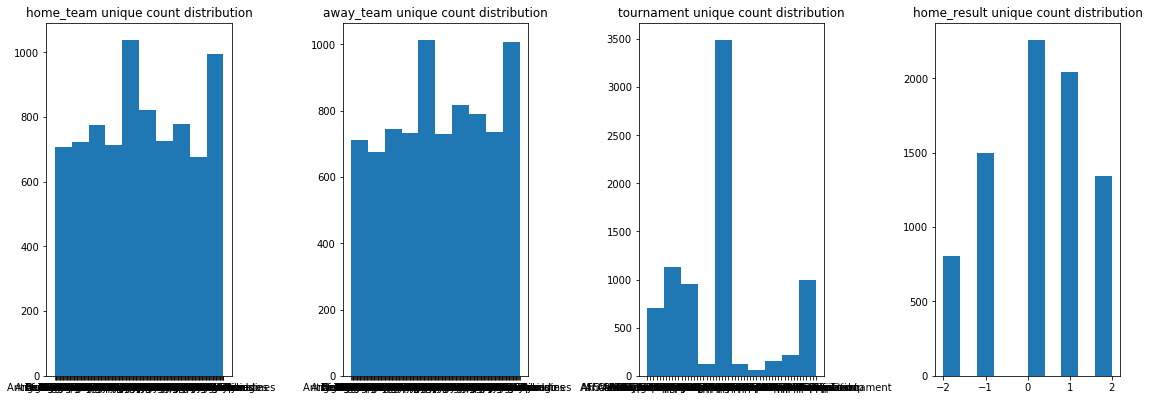

In [11]:
plot_category_freq_distribution(df,['home_team','away_team','tournament','home_result'])

In [12]:
from sklearn.model_selection import train_test_split
Df = df[feature_columns]
Y= df['result']
df_train = Df
y_train = Y

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoders = dict()
categorical_headers = ['home_team','away_team','tournament']

for col in categorical_headers:
    df_train[col] = df_train[col].str.strip()
    encoders[col] = LabelEncoder()
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    
df_train.head()

,home_team,away_team,tournament,Coordinate_home1,Coordinate_home2,Coordinate_away1,Coordinate_away2,Coordinate_match1,Coordinate_match2,month,home_dist,away_dist,home_team_int,away_team_int,tournament_int
0,Afghanistan,Turkmenistan,FIFA World Cup qualification,0.593753,0.929644,0.716130,0.764848,0.601294,0.887319,1.196061,-0.432377,-0.681291,0,201,23
2,Albania,Armenia,UEFA Euro qualification,0.869456,0.089984,0.806336,0.528008,0.873395,0.058083,-1.244301,-0.432377,-0.285868,1,9,49
3,Albania,Belarus,UEFA Euro qualification,0.869456,0.089984,1.374256,0.254646,0.873395,0.058083,1.196061,-0.432377,-0.478344,1,18,49
4,Albania,Belarus,UEFA Euro qualification,0.869456,0.089984,1.374256,0.254646,0.873395,0.058083,-1.244301,-0.432377,-0.478344,1,18,49
5,Albania,Bosnia-Herzegovina,UEFA Euro qualification,0.869456,0.089984,0.968891,0.073621,0.873395,0.058083,0.891016,-0.432377,-0.941529,1,26,49


In [14]:
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)

y_train = y_train.values.astype(np.int)

print(feature_columns)

['home_team_int', 'away_team_int', 'tournament_int', 'Coordinate_home1', 'Coordinate_home2', 'Coordinate_away1', 'Coordinate_away2', 'Coordinate_match1', 'Coordinate_match2', 'month', 'home_dist', 'away_dist']


In [15]:
from sklearn.preprocessing import OneHotEncoder

# now let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)

# the ohe instance will help us to organize our encoded matrix
print(ohe.feature_indices_)
print(X_train_ohe.shape)
print(type(X_train_ohe), '========THIS IS SPARSE ENCODED=======')

[  0 218 435 490]
(7955, 490)
<class 'scipy.sparse.csr.csr_matrix'> ========THIS IS SPARSE ENCODED=======


# Modelling

In [16]:
from sklearn import metrics as mt
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model

Using TensorFlow backend.


In [17]:
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)

ohe1=OneHotEncoder()
y_train = y_train + 2
y_train_ohe = ohe1.fit_transform(y_train.reshape(-1,1))
# and save off the numeric features
X_train_num =  df_train[numeric_headers].values


# create sparse input branch for ohe
inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True)
xSparse = Dense(units=10, activation='relu')(inputsSparse)

# create dense input branch for numeric
inputsDense = Input(shape=(X_train_num.shape[1],),sparse=False)
xDense = Dense(units=10, activation='relu')(inputsDense)

x = concatenate([xSparse, xDense])
predictions = Dense(3,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and Dense layers
model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 490)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           4910        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           100         input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [18]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit([X_train_ohe,X_train_num],y_train_ohe, epochs=1000, batch_size=50, verbose=1, validation_split= 0.2)


Train on 6364 samples, validate on 1591 samples
Epoch 1/1000
6364/6364 [==============================] - 1s 98us/step - loss: 0.2497 - acc: 0.3668 - val_loss: 0.2447 - val_acc: 0.3765
Epoch 2/1000
6364/6364 [==============================] - 1s 151us/step - loss: 0.2438 - acc: 0.3776 - val_loss: 0.2401 - val_acc: 0.3809
Epoch 3/1000
6364/6364 [==============================] - 1s 150us/step - loss: 0.2393 - acc: 0.3869 - val_loss: 0.2366 - val_acc: 0.4010
Epoch 4/1000
6364/6364 [==============================] - 1s 150us/step - loss: 0.2359 - acc: 0.3971 - val_loss: 0.2340 - val_acc: 0.4092
Epoch 5/1000
6364/6364 [==============================] - 1s 122us/step - loss: 0.2333 - acc: 0.3985 - val_loss: 0.2319 - val_acc: 0.4186
Epoch 6/1000
6364/6364 [==============================] - 1s 149us/step - loss: 0.2313 - acc: 0.4043 - val_loss: 0.2303 - val_acc: 0.4167
Epoch 7/1000
6364/6364 [==============================] - 1s 88us/step - loss: 0.2297 - acc: 0.4060 - val_loss: 0.2289 - val_

6364/6364 [==============================] - 1s 83us/step - loss: 0.2185 - acc: 0.4219 - val_loss: 0.2190 - val_acc: 0.4349
Epoch 61/1000
6364/6364 [==============================] - 1s 79us/step - loss: 0.2184 - acc: 0.4217 - val_loss: 0.2189 - val_acc: 0.4356
Epoch 62/1000
6364/6364 [==============================] - 1s 84us/step - loss: 0.2184 - acc: 0.4219 - val_loss: 0.2189 - val_acc: 0.4349
Epoch 63/1000
6364/6364 [==============================] - 1s 80us/step - loss: 0.2183 - acc: 0.4222 - val_loss: 0.2188 - val_acc: 0.4349
Epoch 64/1000
6364/6364 [==============================] - 0s 65us/step - loss: 0.2183 - acc: 0.4221 - val_loss: 0.2188 - val_acc: 0.4349
Epoch 65/1000
6364/6364 [==============================] - 0s 64us/step - loss: 0.2182 - acc: 0.4228 - val_loss: 0.2188 - val_acc: 0.4356
Epoch 66/1000
6364/6364 [==============================] - 0s 64us/step - loss: 0.2182 - acc: 0.4219 - val_loss: 0.2187 - val_acc: 0.4356
Epoch 67/1000
6364/6364 [=======================

6364/6364 [==============================] - 0s 60us/step - loss: 0.2150 - acc: 0.4387 - val_loss: 0.2171 - val_acc: 0.4362
Epoch 179/1000
6364/6364 [==============================] - 0s 59us/step - loss: 0.2149 - acc: 0.4389 - val_loss: 0.2171 - val_acc: 0.4362
Epoch 180/1000
6364/6364 [==============================] - 0s 59us/step - loss: 0.2149 - acc: 0.4392 - val_loss: 0.2171 - val_acc: 0.4362
Epoch 181/1000
6364/6364 [==============================] - 0s 63us/step - loss: 0.2149 - acc: 0.4397 - val_loss: 0.2170 - val_acc: 0.4362
Epoch 182/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.2149 - acc: 0.4395 - val_loss: 0.2170 - val_acc: 0.4362
Epoch 183/1000
6364/6364 [==============================] - 0s 62us/step - loss: 0.2149 - acc: 0.4398 - val_loss: 0.2170 - val_acc: 0.4362
Epoch 184/1000
6364/6364 [==============================] - 0s 65us/step - loss: 0.2148 - acc: 0.4403 - val_loss: 0.2170 - val_acc: 0.4356
Epoch 185/1000
6364/6364 [================

6364/6364 [==============================] - 0s 62us/step - loss: 0.2136 - acc: 0.4475 - val_loss: 0.2166 - val_acc: 0.4400
Epoch 238/1000
6364/6364 [==============================] - 0s 65us/step - loss: 0.2136 - acc: 0.4472 - val_loss: 0.2166 - val_acc: 0.4400
Epoch 239/1000
6364/6364 [==============================] - 0s 60us/step - loss: 0.2135 - acc: 0.4475 - val_loss: 0.2166 - val_acc: 0.4400
Epoch 240/1000
6364/6364 [==============================] - 0s 65us/step - loss: 0.2135 - acc: 0.4474 - val_loss: 0.2166 - val_acc: 0.4400
Epoch 241/1000
6364/6364 [==============================] - 0s 62us/step - loss: 0.2135 - acc: 0.4472 - val_loss: 0.2166 - val_acc: 0.4400
Epoch 242/1000
6364/6364 [==============================] - 0s 63us/step - loss: 0.2135 - acc: 0.4472 - val_loss: 0.2166 - val_acc: 0.4406
Epoch 243/1000
6364/6364 [==============================] - 1s 111us/step - loss: 0.2134 - acc: 0.4475 - val_loss: 0.2166 - val_acc: 0.4406
Epoch 244/1000
6364/6364 [===============

Epoch 296/1000
6364/6364 [==============================] - 1s 105us/step - loss: 0.2119 - acc: 0.4533 - val_loss: 0.2162 - val_acc: 0.4393
Epoch 297/1000
6364/6364 [==============================] - 1s 131us/step - loss: 0.2119 - acc: 0.4544 - val_loss: 0.2162 - val_acc: 0.4400
Epoch 298/1000
6364/6364 [==============================] - 1s 109us/step - loss: 0.2119 - acc: 0.4560 - val_loss: 0.2162 - val_acc: 0.4400
Epoch 299/1000
6364/6364 [==============================] - 1s 84us/step - loss: 0.2118 - acc: 0.4535 - val_loss: 0.2162 - val_acc: 0.4400
Epoch 300/1000
6364/6364 [==============================] - 1s 81us/step - loss: 0.2118 - acc: 0.4547 - val_loss: 0.2162 - val_acc: 0.4393
Epoch 301/1000
6364/6364 [==============================] - 1s 81us/step - loss: 0.2118 - acc: 0.4555 - val_loss: 0.2162 - val_acc: 0.4393
Epoch 302/1000
6364/6364 [==============================] - 1s 81us/step - loss: 0.2118 - acc: 0.4565 - val_loss: 0.2162 - val_acc: 0.4393
Epoch 303/1000
6364/6364

Epoch 355/1000
6364/6364 [==============================] - 1s 86us/step - loss: 0.2099 - acc: 0.4661 - val_loss: 0.2158 - val_acc: 0.4431
Epoch 356/1000
6364/6364 [==============================] - 1s 126us/step - loss: 0.2099 - acc: 0.4665 - val_loss: 0.2158 - val_acc: 0.4431
Epoch 357/1000
6364/6364 [==============================] - 1s 148us/step - loss: 0.2098 - acc: 0.4673 - val_loss: 0.2158 - val_acc: 0.4431
Epoch 358/1000
6364/6364 [==============================] - 1s 149us/step - loss: 0.2098 - acc: 0.4676 - val_loss: 0.2158 - val_acc: 0.4431
Epoch 359/1000
6364/6364 [==============================] - 1s 150us/step - loss: 0.2097 - acc: 0.4670 - val_loss: 0.2157 - val_acc: 0.4431
Epoch 360/1000
6364/6364 [==============================] - 1s 147us/step - loss: 0.2097 - acc: 0.4681 - val_loss: 0.2157 - val_acc: 0.4425
Epoch 361/1000
6364/6364 [==============================] - 1s 136us/step - loss: 0.2097 - acc: 0.4683 - val_loss: 0.2157 - val_acc: 0.4425
Epoch 362/1000
6364/6

Epoch 414/1000
6364/6364 [==============================] - 0s 69us/step - loss: 0.2074 - acc: 0.4788 - val_loss: 0.2153 - val_acc: 0.4456
Epoch 415/1000
6364/6364 [==============================] - 1s 144us/step - loss: 0.2074 - acc: 0.4794 - val_loss: 0.2153 - val_acc: 0.4463
Epoch 416/1000
6364/6364 [==============================] - 0s 69us/step - loss: 0.2074 - acc: 0.4800 - val_loss: 0.2153 - val_acc: 0.4456
Epoch 417/1000
6364/6364 [==============================] - 1s 90us/step - loss: 0.2073 - acc: 0.4796 - val_loss: 0.2153 - val_acc: 0.4456
Epoch 418/1000
6364/6364 [==============================] - 1s 88us/step - loss: 0.2073 - acc: 0.4805 - val_loss: 0.2153 - val_acc: 0.4456
Epoch 419/1000
6364/6364 [==============================] - 1s 86us/step - loss: 0.2072 - acc: 0.4807 - val_loss: 0.2152 - val_acc: 0.4456
Epoch 420/1000
6364/6364 [==============================] - 1s 86us/step - loss: 0.2072 - acc: 0.4811 - val_loss: 0.2152 - val_acc: 0.4463
Epoch 421/1000
6364/6364 [

6364/6364 [==============================] - 0s 57us/step - loss: 0.2018 - acc: 0.5057 - val_loss: 0.2143 - val_acc: 0.4494
Epoch 532/1000
6364/6364 [==============================] - 0s 60us/step - loss: 0.2017 - acc: 0.5063 - val_loss: 0.2143 - val_acc: 0.4494
Epoch 533/1000
6364/6364 [==============================] - 0s 60us/step - loss: 0.2017 - acc: 0.5055 - val_loss: 0.2143 - val_acc: 0.4494
Epoch 534/1000
6364/6364 [==============================] - 1s 127us/step - loss: 0.2016 - acc: 0.5063 - val_loss: 0.2142 - val_acc: 0.4494
Epoch 535/1000
6364/6364 [==============================] - 1s 101us/step - loss: 0.2016 - acc: 0.5060 - val_loss: 0.2142 - val_acc: 0.4500
Epoch 536/1000
6364/6364 [==============================] - 0s 68us/step - loss: 0.2015 - acc: 0.5064 - val_loss: 0.2142 - val_acc: 0.4488
Epoch 537/1000
6364/6364 [==============================] - 0s 65us/step - loss: 0.2015 - acc: 0.5060 - val_loss: 0.2142 - val_acc: 0.4488
Epoch 538/1000
6364/6364 [==============

6364/6364 [==============================] - 0s 42us/step - loss: 0.1989 - acc: 0.5185 - val_loss: 0.2139 - val_acc: 0.4532
Epoch 591/1000
6364/6364 [==============================] - 0s 48us/step - loss: 0.1989 - acc: 0.5179 - val_loss: 0.2139 - val_acc: 0.4551
Epoch 592/1000
6364/6364 [==============================] - 0s 42us/step - loss: 0.1988 - acc: 0.5192 - val_loss: 0.2139 - val_acc: 0.4544
Epoch 593/1000
6364/6364 [==============================] - 0s 45us/step - loss: 0.1988 - acc: 0.5189 - val_loss: 0.2139 - val_acc: 0.4551
Epoch 594/1000
6364/6364 [==============================] - 0s 47us/step - loss: 0.1987 - acc: 0.5185 - val_loss: 0.2139 - val_acc: 0.4551
Epoch 595/1000
6364/6364 [==============================] - 0s 47us/step - loss: 0.1987 - acc: 0.5185 - val_loss: 0.2139 - val_acc: 0.4551
Epoch 596/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.1986 - acc: 0.5185 - val_loss: 0.2139 - val_acc: 0.4551
Epoch 597/1000
6364/6364 [================

6364/6364 [==============================] - 0s 38us/step - loss: 0.1963 - acc: 0.5250 - val_loss: 0.2136 - val_acc: 0.4538
Epoch 650/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1962 - acc: 0.5255 - val_loss: 0.2136 - val_acc: 0.4544
Epoch 651/1000
6364/6364 [==============================] - 0s 39us/step - loss: 0.1962 - acc: 0.5261 - val_loss: 0.2136 - val_acc: 0.4538
Epoch 652/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1961 - acc: 0.5261 - val_loss: 0.2136 - val_acc: 0.4538
Epoch 653/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1961 - acc: 0.5264 - val_loss: 0.2136 - val_acc: 0.4532
Epoch 654/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1960 - acc: 0.5272 - val_loss: 0.2135 - val_acc: 0.4532
Epoch 655/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1960 - acc: 0.5258 - val_loss: 0.2135 - val_acc: 0.4532
Epoch 656/1000
6364/6364 [================

6364/6364 [==============================] - 0s 38us/step - loss: 0.1939 - acc: 0.5311 - val_loss: 0.2133 - val_acc: 0.4469
Epoch 709/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1939 - acc: 0.5313 - val_loss: 0.2133 - val_acc: 0.4469
Epoch 710/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1938 - acc: 0.5311 - val_loss: 0.2133 - val_acc: 0.4469
Epoch 711/1000
6364/6364 [==============================] - 0s 36us/step - loss: 0.1938 - acc: 0.5308 - val_loss: 0.2133 - val_acc: 0.4469
Epoch 712/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1938 - acc: 0.5305 - val_loss: 0.2134 - val_acc: 0.4469
Epoch 713/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1937 - acc: 0.5310 - val_loss: 0.2133 - val_acc: 0.4475
Epoch 714/1000
6364/6364 [==============================] - 0s 39us/step - loss: 0.1937 - acc: 0.5310 - val_loss: 0.2134 - val_acc: 0.4450
Epoch 715/1000
6364/6364 [================

6364/6364 [==============================] - 0s 37us/step - loss: 0.1919 - acc: 0.5371 - val_loss: 0.2132 - val_acc: 0.4450
Epoch 768/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1918 - acc: 0.5369 - val_loss: 0.2132 - val_acc: 0.4463
Epoch 769/1000
6364/6364 [==============================] - 0s 36us/step - loss: 0.1918 - acc: 0.5363 - val_loss: 0.2132 - val_acc: 0.4463
Epoch 770/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1918 - acc: 0.5377 - val_loss: 0.2132 - val_acc: 0.4469
Epoch 771/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1917 - acc: 0.5376 - val_loss: 0.2132 - val_acc: 0.4469
Epoch 772/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1917 - acc: 0.5377 - val_loss: 0.2132 - val_acc: 0.4463
Epoch 773/1000
6364/6364 [==============================] - 0s 36us/step - loss: 0.1917 - acc: 0.5382 - val_loss: 0.2133 - val_acc: 0.4481
Epoch 774/1000
6364/6364 [================

6364/6364 [==============================] - 0s 38us/step - loss: 0.1901 - acc: 0.5432 - val_loss: 0.2132 - val_acc: 0.4444
Epoch 827/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1901 - acc: 0.5438 - val_loss: 0.2132 - val_acc: 0.4437
Epoch 828/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1901 - acc: 0.5429 - val_loss: 0.2132 - val_acc: 0.4444
Epoch 829/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1900 - acc: 0.5434 - val_loss: 0.2132 - val_acc: 0.4444
Epoch 830/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1900 - acc: 0.5434 - val_loss: 0.2131 - val_acc: 0.4431
Epoch 831/1000
6364/6364 [==============================] - 0s 36us/step - loss: 0.1900 - acc: 0.5435 - val_loss: 0.2132 - val_acc: 0.4437
Epoch 832/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1900 - acc: 0.5438 - val_loss: 0.2132 - val_acc: 0.4444
Epoch 833/1000
6364/6364 [================

6364/6364 [==============================] - 0s 38us/step - loss: 0.1886 - acc: 0.5456 - val_loss: 0.2132 - val_acc: 0.4419
Epoch 886/1000
6364/6364 [==============================] - 0s 36us/step - loss: 0.1886 - acc: 0.5462 - val_loss: 0.2132 - val_acc: 0.4419
Epoch 887/1000
6364/6364 [==============================] - 0s 39us/step - loss: 0.1886 - acc: 0.5467 - val_loss: 0.2132 - val_acc: 0.4419
Epoch 888/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1885 - acc: 0.5464 - val_loss: 0.2131 - val_acc: 0.4419
Epoch 889/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1885 - acc: 0.5470 - val_loss: 0.2131 - val_acc: 0.4419
Epoch 890/1000
6364/6364 [==============================] - 0s 36us/step - loss: 0.1885 - acc: 0.5464 - val_loss: 0.2132 - val_acc: 0.4412
Epoch 891/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1885 - acc: 0.5456 - val_loss: 0.2131 - val_acc: 0.4425
Epoch 892/1000
6364/6364 [================

6364/6364 [==============================] - 0s 37us/step - loss: 0.1873 - acc: 0.5514 - val_loss: 0.2132 - val_acc: 0.4419
Epoch 945/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1872 - acc: 0.5511 - val_loss: 0.2131 - val_acc: 0.4393
Epoch 946/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1872 - acc: 0.5517 - val_loss: 0.2131 - val_acc: 0.4400
Epoch 947/1000
6364/6364 [==============================] - 0s 37us/step - loss: 0.1872 - acc: 0.5512 - val_loss: 0.2131 - val_acc: 0.4393
Epoch 948/1000
6364/6364 [==============================] - 0s 38us/step - loss: 0.1872 - acc: 0.5520 - val_loss: 0.2131 - val_acc: 0.4393
Epoch 949/1000
6364/6364 [==============================] - 0s 36us/step - loss: 0.1872 - acc: 0.5511 - val_loss: 0.2131 - val_acc: 0.4406
Epoch 950/1000
6364/6364 [==============================] - 0s 39us/step - loss: 0.1871 - acc: 0.5519 - val_loss: 0.2132 - val_acc: 0.4412
Epoch 951/1000
6364/6364 [================

In [20]:
# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32')
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)

# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False))
x = Dense(units=100, activation='relu')(all_inputs[-1])
all_branch_outputs.append( Dense(units=10,activation='relu')(x) )

## merge the branches together
middle_branch = concatenate(all_branch_outputs)
middle_branch = Dense(units=100,activation = 'relu')(middle_branch)

# merge the branches together
final_branch = Dense(units=3,activation='softmax')(middle_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train_num],
        y_train_ohe, epochs=1000, batch_size=32, verbose=1,validation_split = 0.2)

Train on 6364 samples, validate on 1591 samples
Epoch 1/1000
6364/6364 [==============================] - ETA: 0s - loss: 0.2228 - acc: 0.341 - 1s 88us/step - loss: 0.2226 - acc: 0.3440 - val_loss: 0.2217 - val_acc: 0.3727
Epoch 2/1000
6364/6364 [==============================] - 0s 57us/step - loss: 0.2204 - acc: 0.4111 - val_loss: 0.2199 - val_acc: 0.4337
Epoch 3/1000
6364/6364 [==============================] - 0s 60us/step - loss: 0.2192 - acc: 0.4239 - val_loss: 0.2190 - val_acc: 0.4343
Epoch 4/1000
6364/6364 [==============================] - 0s 56us/step - loss: 0.2186 - acc: 0.4233 - val_loss: 0.2185 - val_acc: 0.4343
Epoch 5/1000
6364/6364 [==============================] - 0s 56us/step - loss: 0.2183 - acc: 0.4235 - val_loss: 0.2182 - val_acc: 0.4343
Epoch 6/1000
6364/6364 [==============================] - 0s 57us/step - loss: 0.2181 - acc: 0.4235 - val_loss: 0.2180 - val_acc: 0.4343
Epoch 7/1000
6364/6364 [==============================] - 0s 59us/step - loss: 0.2180 - acc:

Epoch 60/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.2154 - acc: 0.4266 - val_loss: 0.2171 - val_acc: 0.4337
Epoch 61/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.2153 - acc: 0.4271 - val_loss: 0.2170 - val_acc: 0.4337
Epoch 62/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.2153 - acc: 0.4266 - val_loss: 0.2170 - val_acc: 0.4331
Epoch 63/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.2152 - acc: 0.4271 - val_loss: 0.2170 - val_acc: 0.4337
Epoch 64/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.2152 - acc: 0.4283 - val_loss: 0.2170 - val_acc: 0.4324
Epoch 65/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.2151 - acc: 0.4293 - val_loss: 0.2170 - val_acc: 0.4324
Epoch 66/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.2151 - acc: 0.4282 - val_loss: 0.2169 - val_acc: 0.4331
Epoch 67/1000
6364/6364 [=========

6364/6364 [==============================] - 0s 56us/step - loss: 0.2032 - acc: 0.5014 - val_loss: 0.2135 - val_acc: 0.4601
Epoch 179/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.2030 - acc: 0.5024 - val_loss: 0.2137 - val_acc: 0.4601
Epoch 180/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.2028 - acc: 0.5028 - val_loss: 0.2134 - val_acc: 0.4595
Epoch 181/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.2026 - acc: 0.5036 - val_loss: 0.2134 - val_acc: 0.4601
Epoch 182/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.2024 - acc: 0.5041 - val_loss: 0.2133 - val_acc: 0.4613
Epoch 183/1000
6364/6364 [==============================] - 0s 56us/step - loss: 0.2022 - acc: 0.5058 - val_loss: 0.2133 - val_acc: 0.4620
Epoch 184/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.2020 - acc: 0.5047 - val_loss: 0.2133 - val_acc: 0.4607
Epoch 185/1000
6364/6364 [================

6364/6364 [==============================] - 0s 53us/step - loss: 0.1908 - acc: 0.5336 - val_loss: 0.2112 - val_acc: 0.4569
Epoch 238/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1907 - acc: 0.5346 - val_loss: 0.2108 - val_acc: 0.4626
Epoch 239/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1905 - acc: 0.5346 - val_loss: 0.2108 - val_acc: 0.4632
Epoch 240/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.1903 - acc: 0.5361 - val_loss: 0.2109 - val_acc: 0.4613
Epoch 241/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1901 - acc: 0.5369 - val_loss: 0.2106 - val_acc: 0.4670
Epoch 242/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.1900 - acc: 0.5358 - val_loss: 0.2110 - val_acc: 0.4588
Epoch 243/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.1898 - acc: 0.5374 - val_loss: 0.2108 - val_acc: 0.4613
Epoch 244/1000
6364/6364 [================

6364/6364 [==============================] - 0s 51us/step - loss: 0.1836 - acc: 0.5580 - val_loss: 0.2103 - val_acc: 0.4689
Epoch 297/1000
6364/6364 [==============================] - 0s 54us/step - loss: 0.1835 - acc: 0.5578 - val_loss: 0.2102 - val_acc: 0.4701
Epoch 298/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.1834 - acc: 0.5575 - val_loss: 0.2100 - val_acc: 0.4708
Epoch 299/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1833 - acc: 0.5596 - val_loss: 0.2102 - val_acc: 0.4727
Epoch 300/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.1832 - acc: 0.5575 - val_loss: 0.2100 - val_acc: 0.4727
Epoch 301/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.1831 - acc: 0.5572 - val_loss: 0.2105 - val_acc: 0.4695
Epoch 302/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1830 - acc: 0.5575 - val_loss: 0.2106 - val_acc: 0.4670
Epoch 303/1000
6364/6364 [================

6364/6364 [==============================] - 0s 52us/step - loss: 0.1795 - acc: 0.5693 - val_loss: 0.2101 - val_acc: 0.4701
Epoch 356/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1795 - acc: 0.5688 - val_loss: 0.2101 - val_acc: 0.4676
Epoch 357/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.1794 - acc: 0.5712 - val_loss: 0.2107 - val_acc: 0.4651
Epoch 358/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.1793 - acc: 0.5701 - val_loss: 0.2104 - val_acc: 0.4701
Epoch 359/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.1793 - acc: 0.5701 - val_loss: 0.2106 - val_acc: 0.4645
Epoch 360/1000
6364/6364 [==============================] - 0s 54us/step - loss: 0.1792 - acc: 0.5713 - val_loss: 0.2102 - val_acc: 0.4689
Epoch 361/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.1792 - acc: 0.5718 - val_loss: 0.2109 - val_acc: 0.4689
Epoch 362/1000
6364/6364 [================

6364/6364 [==============================] - 0s 57us/step - loss: 0.1767 - acc: 0.5833 - val_loss: 0.2114 - val_acc: 0.4670
Epoch 415/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1766 - acc: 0.5811 - val_loss: 0.2116 - val_acc: 0.4632
Epoch 416/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1767 - acc: 0.5809 - val_loss: 0.2114 - val_acc: 0.4626
Epoch 417/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1767 - acc: 0.5806 - val_loss: 0.2115 - val_acc: 0.4664
Epoch 418/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1765 - acc: 0.5803 - val_loss: 0.2115 - val_acc: 0.4670
Epoch 419/1000
6364/6364 [==============================] - 0s 60us/step - loss: 0.1765 - acc: 0.5803 - val_loss: 0.2118 - val_acc: 0.4607
Epoch 420/1000
6364/6364 [==============================] - 0s 60us/step - loss: 0.1765 - acc: 0.5811 - val_loss: 0.2111 - val_acc: 0.4752
Epoch 421/1000
6364/6364 [================

6364/6364 [==============================] - 0s 57us/step - loss: 0.1745 - acc: 0.5858 - val_loss: 0.2127 - val_acc: 0.4689
Epoch 474/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.1744 - acc: 0.5888 - val_loss: 0.2126 - val_acc: 0.4733
Epoch 475/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1743 - acc: 0.5885 - val_loss: 0.2125 - val_acc: 0.4733
Epoch 476/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1743 - acc: 0.5896 - val_loss: 0.2129 - val_acc: 0.4708
Epoch 477/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1743 - acc: 0.5893 - val_loss: 0.2132 - val_acc: 0.4632
Epoch 478/1000
6364/6364 [==============================] - 0s 54us/step - loss: 0.1742 - acc: 0.5891 - val_loss: 0.2125 - val_acc: 0.4733
Epoch 479/1000
6364/6364 [==============================] - 0s 57us/step - loss: 0.1742 - acc: 0.5918 - val_loss: 0.2130 - val_acc: 0.4695
Epoch 480/1000
6364/6364 [================

6364/6364 [==============================] - 0s 56us/step - loss: 0.1723 - acc: 0.5965 - val_loss: 0.2149 - val_acc: 0.4645
Epoch 533/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1723 - acc: 0.5970 - val_loss: 0.2144 - val_acc: 0.4657
Epoch 534/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.1722 - acc: 0.5984 - val_loss: 0.2140 - val_acc: 0.4695
Epoch 535/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1722 - acc: 0.6009 - val_loss: 0.2143 - val_acc: 0.4701
Epoch 536/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1720 - acc: 0.5995 - val_loss: 0.2148 - val_acc: 0.4639
Epoch 537/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1720 - acc: 0.5992 - val_loss: 0.2148 - val_acc: 0.4664
Epoch 538/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1720 - acc: 0.5970 - val_loss: 0.2149 - val_acc: 0.4664
Epoch 539/1000
6364/6364 [================

6364/6364 [==============================] - 0s 55us/step - loss: 0.1700 - acc: 0.6050 - val_loss: 0.2166 - val_acc: 0.4569
Epoch 592/1000
6364/6364 [==============================] - 0s 57us/step - loss: 0.1700 - acc: 0.6056 - val_loss: 0.2164 - val_acc: 0.4601
Epoch 593/1000
6364/6364 [==============================] - 0s 60us/step - loss: 0.1701 - acc: 0.6069 - val_loss: 0.2162 - val_acc: 0.4651
Epoch 594/1000
6364/6364 [==============================] - 0s 61us/step - loss: 0.1700 - acc: 0.6111 - val_loss: 0.2166 - val_acc: 0.4601
Epoch 595/1000
6364/6364 [==============================] - 0s 50us/step - loss: 0.1700 - acc: 0.6072 - val_loss: 0.2172 - val_acc: 0.4551
Epoch 596/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1698 - acc: 0.6080 - val_loss: 0.2161 - val_acc: 0.4689
Epoch 597/1000
6364/6364 [==============================] - 0s 54us/step - loss: 0.1697 - acc: 0.6094 - val_loss: 0.2165 - val_acc: 0.4733
Epoch 598/1000
6364/6364 [================

6364/6364 [==============================] - 0s 49us/step - loss: 0.1681 - acc: 0.6160 - val_loss: 0.2186 - val_acc: 0.4613
Epoch 651/1000
6364/6364 [==============================] - 0s 50us/step - loss: 0.1678 - acc: 0.6172 - val_loss: 0.2199 - val_acc: 0.4532
Epoch 652/1000
6364/6364 [==============================] - 0s 49us/step - loss: 0.1679 - acc: 0.6155 - val_loss: 0.2194 - val_acc: 0.4519
Epoch 653/1000
6364/6364 [==============================] - 0s 50us/step - loss: 0.1678 - acc: 0.6153 - val_loss: 0.2191 - val_acc: 0.4639
Epoch 654/1000
6364/6364 [==============================] - 0s 50us/step - loss: 0.1678 - acc: 0.6147 - val_loss: 0.2195 - val_acc: 0.4557
Epoch 655/1000
6364/6364 [==============================] - 0s 48us/step - loss: 0.1677 - acc: 0.6136 - val_loss: 0.2186 - val_acc: 0.4569
Epoch 656/1000
6364/6364 [==============================] - 0s 50us/step - loss: 0.1677 - acc: 0.6182 - val_loss: 0.2194 - val_acc: 0.4582
Epoch 657/1000
6364/6364 [================

Epoch 709/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.1663 - acc: 0.6235 - val_loss: 0.2212 - val_acc: 0.4595
Epoch 710/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.1661 - acc: 0.6229 - val_loss: 0.2212 - val_acc: 0.4569
Epoch 711/1000
6364/6364 [==============================] - 0s 63us/step - loss: 0.1662 - acc: 0.6219 - val_loss: 0.2216 - val_acc: 0.4500
Epoch 712/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1662 - acc: 0.6182 - val_loss: 0.2215 - val_acc: 0.4525
Epoch 713/1000
6364/6364 [==============================] - 0s 63us/step - loss: 0.1660 - acc: 0.6210 - val_loss: 0.2215 - val_acc: 0.4488
Epoch 714/1000
6364/6364 [==============================] - 0s 56us/step - loss: 0.1661 - acc: 0.6260 - val_loss: 0.2222 - val_acc: 0.4563
Epoch 715/1000
6364/6364 [==============================] - 0s 64us/step - loss: 0.1660 - acc: 0.6194 - val_loss: 0.2226 - val_acc: 0.4375
Epoch 716/1000
6364/6364 [=

Epoch 768/1000
6364/6364 [==============================] - 0s 54us/step - loss: 0.1646 - acc: 0.6292 - val_loss: 0.2239 - val_acc: 0.4569
Epoch 769/1000
6364/6364 [==============================] - 0s 57us/step - loss: 0.1647 - acc: 0.6273 - val_loss: 0.2244 - val_acc: 0.4651
Epoch 770/1000
6364/6364 [==============================] - 0s 56us/step - loss: 0.1645 - acc: 0.6296 - val_loss: 0.2248 - val_acc: 0.4437
Epoch 771/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1644 - acc: 0.6306 - val_loss: 0.2252 - val_acc: 0.4582
Epoch 772/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1644 - acc: 0.6348 - val_loss: 0.2267 - val_acc: 0.4287
Epoch 773/1000
6364/6364 [==============================] - 0s 56us/step - loss: 0.1646 - acc: 0.6312 - val_loss: 0.2247 - val_acc: 0.4463
Epoch 774/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1644 - acc: 0.6314 - val_loss: 0.2251 - val_acc: 0.4544
Epoch 775/1000
6364/6364 [=

Epoch 827/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1632 - acc: 0.6334 - val_loss: 0.2266 - val_acc: 0.4519
Epoch 828/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1632 - acc: 0.6323 - val_loss: 0.2272 - val_acc: 0.4500
Epoch 829/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1631 - acc: 0.6386 - val_loss: 0.2264 - val_acc: 0.4557
Epoch 830/1000
6364/6364 [==============================] - 0s 52us/step - loss: 0.1632 - acc: 0.6343 - val_loss: 0.2280 - val_acc: 0.4400
Epoch 831/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1632 - acc: 0.6337 - val_loss: 0.2280 - val_acc: 0.4412
Epoch 832/1000
6364/6364 [==============================] - 0s 56us/step - loss: 0.1631 - acc: 0.6350 - val_loss: 0.2265 - val_acc: 0.4500
Epoch 833/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1630 - acc: 0.6373 - val_loss: 0.2275 - val_acc: 0.4431
Epoch 834/1000
6364/6364 [=

Epoch 886/1000
6364/6364 [==============================] - 0s 60us/step - loss: 0.1618 - acc: 0.6372 - val_loss: 0.2290 - val_acc: 0.4500
Epoch 887/1000
6364/6364 [==============================] - 0s 61us/step - loss: 0.1617 - acc: 0.6362 - val_loss: 0.2304 - val_acc: 0.4519
Epoch 888/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1621 - acc: 0.6353 - val_loss: 0.2292 - val_acc: 0.4481
Epoch 889/1000
6364/6364 [==============================] - 0s 57us/step - loss: 0.1619 - acc: 0.6376 - val_loss: 0.2299 - val_acc: 0.4437
Epoch 890/1000
6364/6364 [==============================] - 0s 58us/step - loss: 0.1617 - acc: 0.6403 - val_loss: 0.2292 - val_acc: 0.4475
Epoch 891/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1617 - acc: 0.6362 - val_loss: 0.2294 - val_acc: 0.4532
Epoch 892/1000
6364/6364 [==============================] - 0s 64us/step - loss: 0.1620 - acc: 0.6386 - val_loss: 0.2294 - val_acc: 0.4544
Epoch 893/1000
6364/6364 [=

Epoch 945/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1610 - acc: 0.6427 - val_loss: 0.2317 - val_acc: 0.4431
Epoch 946/1000
6364/6364 [==============================] - 0s 55us/step - loss: 0.1609 - acc: 0.6430 - val_loss: 0.2318 - val_acc: 0.4544
Epoch 947/1000
6364/6364 [==============================] - 0s 53us/step - loss: 0.1608 - acc: 0.6394 - val_loss: 0.2314 - val_acc: 0.4419
Epoch 948/1000
6364/6364 [==============================] - 0s 51us/step - loss: 0.1606 - acc: 0.6424 - val_loss: 0.2326 - val_acc: 0.4513
Epoch 949/1000
6364/6364 [==============================] - 0s 54us/step - loss: 0.1609 - acc: 0.6464 - val_loss: 0.2318 - val_acc: 0.4500
Epoch 950/1000
6364/6364 [==============================] - 0s 56us/step - loss: 0.1606 - acc: 0.6414 - val_loss: 0.2338 - val_acc: 0.4343
Epoch 951/1000
6364/6364 [==============================] - 0s 56us/step - loss: 0.1605 - acc: 0.6409 - val_loss: 0.2313 - val_acc: 0.4488
Epoch 952/1000
6364/6364 [=